In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,7)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns
from keras.callbacks import *
from sklearn.metrics import *

In [2]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\GTWYDaily.csv', index_col=0, parse_dates=True)

# df = df[['Gas', 'Electric', 'Water', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed']]

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
values = df.values

# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [5]:
# specify the number of lag hours/days
n_hours = 24
n_features = 8

In [6]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var1(t-23),var2(t-23),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
24,0.107019,0.022507,0.110838,0.591425,0.641306,0.553251,0.539964,0.251043,0.002619,0.022159,...,0.394316,0.189595,0.841636,0.022821,0.235444,0.586837,0.616528,0.523543,0.515986,0.043017
25,0.002619,0.022159,0.001870,0.573909,0.606920,0.553812,0.507105,0.595597,0.000119,0.022854,...,0.515986,0.043017,0.820418,0.022489,0.162303,0.606583,0.595746,0.520179,0.388988,0.258137
26,0.000119,0.022854,0.001645,0.530855,0.650833,0.557735,0.800178,0.571881,0.002427,0.023446,...,0.388988,0.258137,0.819061,0.023371,0.185376,0.624707,0.714321,0.480942,0.629663,0.544721
27,0.002427,0.023446,0.003605,0.557838,0.609921,0.558857,0.568384,0.702323,0.000000,0.022192,...,0.629663,0.544721,0.809337,0.022289,0.178324,0.654009,0.646331,0.467489,0.375666,0.516101
28,0.000000,0.022192,0.004912,0.549486,0.682430,0.523543,0.829485,0.283767,0.119268,0.217261,...,0.375666,0.516101,0.785303,0.021880,0.166066,0.644086,0.678352,0.587444,0.480462,0.252921


In [7]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 7
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2555, 192) 2555 (2555,)
(2555, 24, 8) (2555,) (2451, 24, 8) (2451,)


In [8]:
# design network
# model = Sequential()
# # adding layers to the model.
# model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=True))
# model.add(LSTM(25, activation='relu', return_sequences=False))
# # # # model.add(Dropout(0.01))
# model.add(Dense(1))

model = Sequential()
model.add(Bidirectional(LSTM(units=50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False)))
# model.add(Bidirectional(LSTM(units=25, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=25, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=25, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=25, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=25, activation='relu', return_sequences=True)))
# model.add(Bidirectional(LSTM(units=25, activation='relu')))
# # model.add(Dropout(rate=0.2))
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)

# fit network
history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Epoch 1/50
80/80 [==============================] - 4s 13ms/step - loss: 0.0552 - val_loss: 0.0252
Epoch 2/50
80/80 [==============================] - 1s 9ms/step - loss: 0.0348 - val_loss: 0.0226
Epoch 3/50
80/80 [==============================] - 1s 9ms/step - loss: 0.0331 - val_loss: 0.0220
Epoch 4/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0319 - val_loss: 0.0213
Epoch 5/50
80/80 [==============================] - 1s 11ms/step - loss: 0.0303 - val_loss: 0.0208
Epoch 6/50
80/80 [==============================] - 1s 11ms/step - loss: 0.0280 - val_loss: 0.0182
Epoch 7/50
80/80 [==============================] - 1s 10ms/step - loss: 0.0264 - val_loss: 0.0168
Epoch 8/50
80/80 [==============================] - 1s 9ms/step - loss: 0.0244 - val_loss: 0.0152
Epoch 9/50
80/80 [==============================] - 1s 9ms/step - loss: 0.0221 - val_loss: 0.0144
Epoch 10/50
80/80 [==============================] - 1s 9ms/step - loss: 0.0196 - val_loss: 0.0140
Epoch 11/50
80

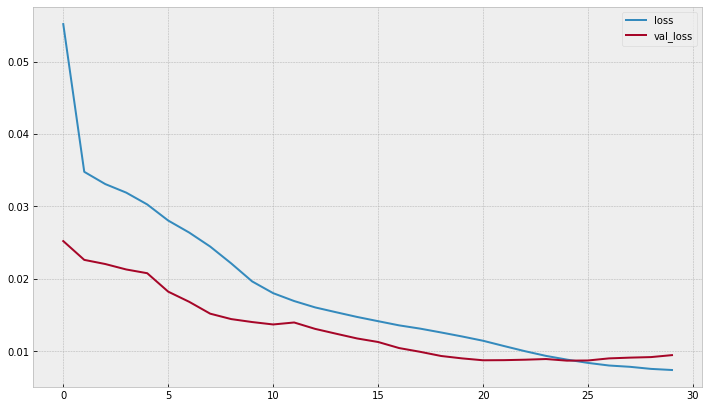

In [10]:
# Plotting the loss and validation loss over the epochs.
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import *

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
# rmse = np.sqrt(mean_squared_error(test_y, yhat))
# mse = mean_squared_error(test_y, yhat)
# mae = mean_absolute_error(test_y, yhat)
# r2 = r2_score(test_y, yhat)


rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mse = mean_squared_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)

print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

Test RMSE: 10.721
Test MSE: 114.944
Test MAE: 8.437
Test R2: 0.569


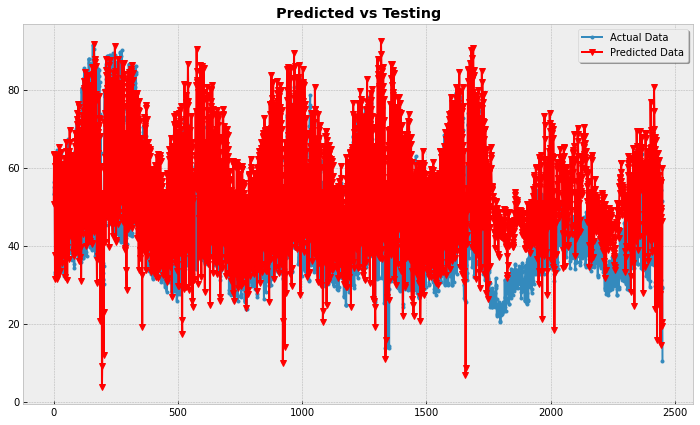

In [12]:
plt.plot(inv_y.flatten(), marker='.', label='Actual Data')
plt.plot(inv_yhat.flatten(), marker='v', color='r', label='Predicted Data')
plt.title('Predicted vs Testing', fontweight='bold')
plt.legend(shadow=True);